In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard
import time

In [72]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/original/train"
NAME = "Covid-Mode_new-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

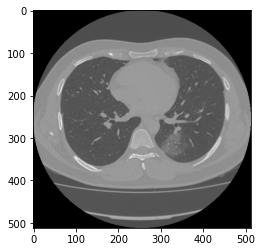

In [4]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [73]:
# Data Augmentation

IMAGE_SIZE    = (244, 244)

BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 10
LEARNING_RATE =0.0005 

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip= True ,
    validation_split = 0.2)

In [74]:
print("Training samples:")
train_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary")

print("\n Validation samples: ")
                                                  

valid_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary" )





Training samples:
Found 8988 images belonging to 2 classes.

 Validation samples: 
Found 2245 images belonging to 2 classes.


In [70]:
# Output classes
train_batches.class_indices

{'covid': 0, 'normal': 1}

In [71]:

df = pd.DataFrame()
df["labels"] = list(train_batches.classes)

In [44]:
df["labels"].value_counts()

0    4576
1    4412
Name: labels, dtype: int64

In [45]:
len(train_batches.classes)

8988

##  Distribution of classes

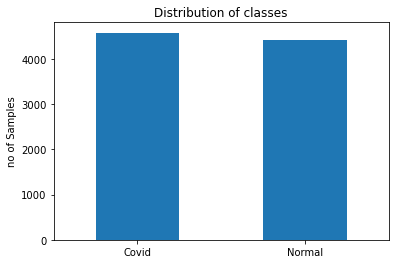

In [46]:
df["labels"].value_counts().plot(kind='bar')
plt.xticks([0,1], ["Covid", "Normal"], rotation='horizontal')
plt.ylabel('no of Samples')
plt.title('Distribution of classes')
plt.show()

In [75]:
# Model Structure
model = Sequential()

model.add(Conv2D( 32, kernel_size=(3,3),activation='relu',input_shape=(244, 244,3)))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = keras.losses.binary_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

In [76]:
result = model.fit_generator(train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs= NUM_EPOCHS,
                        callbacks=[tensorboard])


Epoch 1/10
281/281 [==============================] - 809s 3s/step - loss: 0.5210 - accuracy: 0.7743 - val_loss: 0.6155 - val_accuracy: 0.5915
Epoch 2/10
281/281 [==============================] - 809s 3s/step - loss: 0.4380 - accuracy: 0.8161 - val_loss: 0.3681 - val_accuracy: 0.8347
Epoch 3/10
281/281 [==============================] - 787s 3s/step - loss: 0.4072 - accuracy: 0.8269 - val_loss: 0.3569 - val_accuracy: 0.8388
Epoch 4/10
281/281 [==============================] - 757s 3s/step - loss: 0.3823 - accuracy: 0.8402 - val_loss: 0.3415 - val_accuracy: 0.8526
Epoch 5/10
281/281 [==============================] - 782s 3s/step - loss: 0.3558 - accuracy: 0.8504 - val_loss: 0.3287 - val_accuracy: 0.8584
Epoch 6/10
281/281 [==============================] - 779s 3s/step - loss: 0.3468 - accuracy: 0.8563 - val_loss: 0.2956 - val_accuracy: 0.8748
Epoch 7/10
281/281 [==============================] - 755s 3s/step - loss: 0.3347 - accuracy: 0.8615 - val_loss: 0.2989 - val_accuracy: 0.8775

In [80]:
model.save("D:/Project2022/models/image/original.h5")

## Evaluating the model on Test dataset

In [113]:
test_dir = "D:/Project2022/res/split_dataset/original/test"

test_datagen = image.ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,      
        class_mode="binary")

Found 2809 images belonging to 2 classes.


In [114]:
x = model.evaluate(eval_generator,
                       steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                       use_multiprocessing = False,
                       verbose = 1,
                       workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

88/88 [==============================] - 2s 25ms/step - loss: 0.3623 - accuracy: 0.8182
Test loss: 0.3622789680957794
Test accuracy: 0.8181818127632141


In [115]:
pred = model.predict(eval_generator,len(eval_generator.classes),verbose=1)
print("Predictions finished")

2809/2809 [==============================] - 70s 25ms/step
Predictions finished


In [116]:
y_test = eval_generator.classes
y_pred = (pred > 0.5).astype("int32")

In [117]:
from sklearn.metrics import classification_report 
print(classification_report(eval_generator.classes, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.95      0.82      0.88      1430
      Normal       0.83      0.96      0.89      1379

    accuracy                           0.89      2809
   macro avg       0.89      0.89      0.89      2809
weighted avg       0.89      0.89      0.88      2809



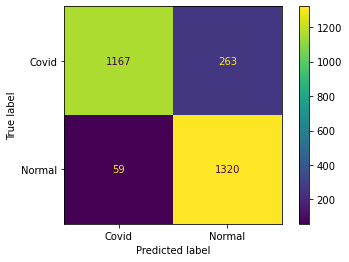

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_generator.classes, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
